# SHMSL Color Reflectance (RSC)

The Section-Half MultiSensor Logger (SHMSL) is used to measure magnetic susceptibility, core surface profiles and colorimetric properties calculated from color spectra. In this workbook we will look only at the color reflectance portion, exploring how to read and process the raw data, calculate Tristimulus XYZ manually, and plot results.

In [1]:
# force Jupyter to autoreload modules when they have been edited
# this helps keep the iodp module current as it is actively developed.
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os
from importlib import reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colour
import colour.plotting as cp

from iodp import shmsl, utils


In [5]:
# Ensure we are in the PhysicalProperties root folder
if not os.getcwd().endswith("PhysicalProperties"):
    print("Current working directory:", os.getcwd())
    os.chdir("../")
    
print("New current working directory:", os.getcwd())

    

New current working directory: d:\archive\hd_files\data_analysis\50_laboratory_notebooks\SOD-Laboratory\PhysicalProperties


# Anatomy of a RSC Measurement

An RSC measurement is taken on the exposed face of a split core section. One test consists of multiple shots typically taken at 1-2.5 cm offsets along the center of the section. Before a measurement is made the spectrometer (a QEPro model) collects a dark calibration and a white calibration and stores the spectra in the Labview .ini file. The calibration spectra are also exported as two .csv files (named with the "STND" prefix). At the onset of a measurement, the probe head will touch down on a white quality control standard (CNTRL) and output its raw data to file. This control standard is used to monitor instrument drift and is not used for colorimeteric calculations. The measurement itself is stored in the RUN folder.

Each measurement exists as two csvs, one with the raw spectral counts, and the other with normalized (flatfield corrected) reflectance spectra teogether with calculated colorimeteric values. The final RSC file is a XML-like file containing measurement summaries and file references that IODP software would use to import data into its Oracle database.

Note: The SHMSL also exports MSPOINT and PROFILE files to the same directory, but they are removed here as they do not pertain to this RSC analysis.

- Root:
    - {test_name}_{datetime}.RSC
    - {white_standard_name}_{datetime}.RSC
    - I_PI_QEPRO.ini_{datetime}.

    - CNTRL:
        - NORM_{white_standard_name}_{datetime}_RSC.csv
        - RAW_{white_standard_name}_{datetime}_RSC.csv
    - RUN:
        - NORM_{test_name}_{datetime}_RSC.csv
        - RAW_{test_name}_{datetime}_RSC.csv
    - STND
        - STND-DARK_{datetime}_RSC.csv
        - STND-WHITE_{datetime}_RSC.csv

## Importing Color Reflectance Data

### Reading SHMSL .RSC files

RSC files contain summary colorimetric measurements and summary metadata in an XML-like format. RSC do not contain the measurement spectra. RSC files are generated for samples and measurements of a white calibration standard, but not for a dark calibration standard. 

In [7]:

# Import results of a white calibration measurement

# example = "./data/input/rsc/covered/WHITE_20241120220337_CNTL.RSC"
example = "./data/input/rsc/uncovered/WHITE_20241120212713_CNTL.RSC"

df = shmsl.read_shmsl_rsc(example)

print(f"White calibration shape: {df.shape}")
print(f"White calibration XYZ: {df.loc[0, ['tristimulus_x','tristimulus_y','tristimulus_z']].values}")
print()

# Import results of a test measurement

print("Example of a RSC file converted to tabular format:")
# example = "./data/input/rsc/covered/COVERED-STANDARDS-20241120_20241120220339.RSC"
example = "./data/input/rsc/uncovered/UNCOVERED-STANDARDS-20241120_20241120212715.RSC"
df = utils.read_instrument_file(example, as_dataframe=True)
df.head()



White calibration shape: (1, 26)
White calibration XYZ: [94.799999999999997 97.400000000000006 118.90000000000001]

Example of a RSC file converted to tabular format:


d:\archive\hd_files\data_analysis\50_laboratory_notebooks\sod-laboratory\iodp\iodp\shmsl.py:189: UserWarning: File preamble does not contain 'RSC'
  warnings.warn("File preamble does not contain 'RSC'")


,datetime,labelid,user,text_id,instrument,instrument_group,observed_length,comment,geometry,illuminant,...,offset,cielab_l_star,cielab_a_star,cielab_b_star,hue,chroma,tristimulus_x,tristimulus_y,tristimulus_z,sample_time
0,2024-11-20 21:27:15 UTC,UNCOVERED-STANDARDS-20241120,,UNCOVERED_STANDARDS_20241120,"0) OCEAN INSIGHT MODEL: QEPRO S/N: QEP00732, 1...",SHMSL,116.82,These are the spectralon standards. The last s...,d/8 SPE,D50,...,2.00,22.86,17.30,4.42,14.32,17.85,4.79,3.76,3.29,320000
1,2024-11-20 21:27:15 UTC,UNCOVERED-STANDARDS-20241120,,UNCOVERED_STANDARDS_20241120,"0) OCEAN INSIGHT MODEL: QEPRO S/N: QEP00732, 1...",SHMSL,116.82,These are the spectralon standards. The last s...,d/8 SPE,D50,...,3.00,47.44,50.64,25.69,26.90,56.78,25.82,16.36,7.87,320000
2,2024-11-20 21:27:15 UTC,UNCOVERED-STANDARDS-20241120,,UNCOVERED_STANDARDS_20241120,"0) OCEAN INSIGHT MODEL: QEPRO S/N: QEP00732, 1...",SHMSL,116.82,These are the spectralon standards. The last s...,d/8 SPE,D50,...,4.00,47.38,50.88,26.12,27.17,57.20,25.82,16.31,7.72,320000
3,2024-11-20 21:27:15 UTC,UNCOVERED-STANDARDS-20241120,,UNCOVERED_STANDARDS_20241120,"0) OCEAN INSIGHT MODEL: QEPRO S/N: QEP00732, 1...",SHMSL,116.82,These are the spectralon standards. The last s...,d/8 SPE,D50,...,5.00,47.65,50.81,25.91,27.02,57.03,26.09,16.52,7.91,320000
4,2024-11-20 21:27:15 UTC,UNCOVERED-STANDARDS-20241120,,UNCOVERED_STANDARDS_20241120,"0) OCEAN INSIGHT MODEL: QEPRO S/N: QEP00732, 1...",SHMSL,116.82,These are the spectralon standards. The last s...,d/8 SPE,D50,...,6.00,47.58,50.95,26.07,27.09,57.23,26.05,16.47,7.83,320000


### Reading SHMSL .csv files

There are three types of csv files output by the SHMSL. Each may be identified by a prefix added to the sample name.

- STND_: Either STND-DARK or STND-WHITE. These are the dark and white calibration spectra for the QEPro used to convert RAW spectra into NORM data using a flatfield correction. 
- RAW_: These files are of sample measurements or white calibration quality control standards and consist of raw spectra taken at multiple offsets on the sample and some metadata.
- NORM_: These files are of sample measurements or white calibration quality control standards and consist of normalized spectra (flat-field corrected), colorimetric values, and some metadata.



The .csv files contain the measured spectra and measurement parameters but do not contain calculated colorimetric values.



In [8]:
# Import the spectrophotometric results for a measurement test

# example = './data/input/rsc/covered/RUN/RAW_COVERED-STANDARDS-20241120_2411202203393_RSC.csv'
example = './data/input/rsc/uncovered/RUN/RAW_UNCOVERED-STANDARDS-20241120_2411202127153_RSC.csv'

# example here gets the contents of the entire file in tabular format
df = shmsl.read_shmsl_rsc_csv(file=example,spectra_only=False)
df.head()

,offset(cm),sensor_temp(C),dark_pixel,data_type,bin_interval(nm),start_wavelength,end_wavelength,time (us),390.0,392.0,...,700.0,702.0,704.0,706.0,708.0,710.0,712.0,714.0,716.0,718.0
0,2.0,48.623,1675.2,RAW,2,390,720,320000,2284.978,2560.910,...,19439.480,19269.148,19144.345,19022.706,18868.538,18756.021,18595.127,18448.829,18148.381,17808.689
1,3.0,48.425,1805.5,RAW,2,390,720,320000,3203.962,3790.395,...,172773.766,172441.958,172199.030,171790.176,171455.690,170905.434,170263.713,169329.353,167734.276,164798.189
2,4.0,48.623,1802.5,RAW,2,390,720,320000,3167.467,3751.759,...,173437.722,173140.954,172829.012,172448.429,171971.449,171617.432,170911.640,170078.912,168382.717,165474.673
3,5.0,48.623,1801.3,RAW,2,390,720,320000,3198.554,3783.486,...,173824.885,173584.534,173321.982,172857.903,172491.738,172028.139,171375.617,170395.200,168711.022,165903.941
4,6.0,48.623,1802.2,RAW,2,390,720,320000,3192.358,3782.577,...,173592.930,173290.264,173048.261,172577.550,172174.179,171834.274,171133.092,170213.072,168528.769,165668.298


In [9]:
# Import the spectrophotometric results for a measurement test, but only return the spectra and offsets
example = './data/input/rsc/covered/RUN/RAW_COVERED-STANDARDS-20241120_2411202203393_RSC.csv'

# example here gets the contents of only the spectra
df = shmsl.read_shmsl_rsc_csv(file=example,spectra_only=True)
df.head()

,offset(cm),390.0,392.0,394.0,396.0,398.0,400.0,402.0,404.0,406.0,...,700.0,702.0,704.0,706.0,708.0,710.0,712.0,714.0,716.0,718.0
0,1.0,2005.679,2158.152,2329.665,2498.533,2666.800,2798.496,2898.446,2959.691,2954.350,...,4886.857,4879.753,4878.315,4878.959,4863.861,4857.330,4850.965,4833.720,4799.907,4755.854
1,2.0,7699.964,10366.735,13490.647,16559.735,19367.491,21795.085,23718.386,24625.333,24539.149,...,46602.051,46356.468,46158.691,45835.425,45571.053,45406.537,45046.085,44712.034,44169.332,43299.623
2,3.0,4855.934,6076.519,7469.927,8880.017,10151.958,11200.760,12074.093,12527.000,12509.594,...,158377.077,157989.736,157759.788,157446.964,157181.075,156656.436,155858.165,155085.852,153487.718,151014.813
3,4.0,3711.872,4491.093,5459.208,6400.987,7211.466,7928.118,8511.722,8782.000,8756.226,...,164122.173,163858.005,163626.618,163294.818,163009.197,162522.969,161806.521,161118.496,159376.522,156786.021
4,5.0,3998.566,4944.912,6015.765,7118.950,8070.783,8905.380,9595.177,9933.358,9886.379,...,166313.389,166044.424,165880.194,165466.014,165153.419,164593.051,163888.344,163017.819,161538.864,158887.957


In [10]:

# Import the white control standards results for a measurement test
# example = './data/input/rsc/covered/CNTRL/NORM_STND-WHITE_2411202203373_RSC.csv'
example = './data/input/rsc/uncovered/CNTRL/NORM_STND-WHITE_2411202127133_RSC.csv'

df = shmsl.read_shmsl_rsc_csv(file=example,spectra_only=False)
df.head()

,label_id,text_id,timestamp,offset(cm),X,Y,Z,L,*a,*b,...,700.0,702.0,704.0,706.0,708.0,710.0,712.0,714.0,716.0,718.0
0,STND-White,WHITE,14-11-10 03:35:293 UTC,0.3,94.797,97.4,118.904,98.986,4.314,-8.661,...,97.983,97.959,98.004,97.885,97.947,98.069,97.955,98.015,98.066,97.887


### Reading SHMSL .ini files

The SMSHL ini files contain the most metadata which describes the state of the SHMSL's LabView control software during measurement. It is the only location where the dark calibration values are stored.

In [11]:
path = './data/input/rsc/I_PI_QEPRO.ini_20241120205824'

In [ ]:
# Note: The .ini content here is returned as a dataframe and a ConfigParser object. The latter simplifies referencing values.
df, config = utils.read_instrument_ini(path)
df

,value
key,
mgi rwa section options,2.0.1 %04Y%02m%02d %02H%02M%S%25u*~|.%d*~|....
ims framework-major,14
ims framework-minor,0
plugin-major,0
plugin-minor,0
...,...
section and control data paths.config data paths 0..type,config
section and control data paths.config data paths 0..path,C:\IMS\CONFIG_SHMSL\I_PI_QEPRO.INI
background data paths .calibration paths,<0>


In [13]:
print(f'Sections in the ini file: {config.sections()}')

print(f'Fields in the QEPro Private Data field: {[x for x in config['QEPro Private Data']]}')

# Here we are accessing the contents of a field from a section.
config['QEPro Private Data']['white data.counts']

Sections in the ini file: ['IMS Version', 'USER', 'QEPro Private Data']
Fields in the QEPro Private Data field: ['mgi rwa section options', 'spectral daq active?', 'trigger mode', 'power', 'lamp enabled', 'daq.daq stack n', 'daq.white cal stack', 'daq.dark cal stack', 'daq.percent staturation', 'daq.median filter rank', 'daq.illuminant', 'daq.geometry', 'daq.interval (nm spacing)', 'daq.number of pixels', 'daq.starting wavelength', 'daq.ending wavelength', 'white data.counts', 'white data.lambda', 'dark data.counts', 'dark data.lambda', 'nonlnear correction.size', 'nonlnear correction.values', 'wavelenght correction.size', 'wavelenght correction.values', 'stray light.size', 'stray light.values', 'dark pixel.daq', 'dark pixel.dark cal', 'dark pixel.white cal', 'inegration time.time', 'inegration time.integration start', 'inegration time.integration step', 'buffer.max available', 'buffer.current size', 'buffer.max buffer size', 'buffer.number of spectra', 'tec.enabled', 'tec.stable', 'te

'<165>24608.34684919,34479.75268147,45900.38672078,56919.72043759,67013.69697048,76149.76400334,83449.45614271,85940,84385.55693312,76796.36639024,67030.62666341,58069.61009634,50687.86395108,45338.24769965,41575.50961734,38780.16978981,37231.89496522,37207,38186.89483963,40339.04174395,43374.09961691,46601.83671176,49734.24355236,52990.15737699,55318.9208538,57308.19074305,59366.09502933,61163.93370669,62109,61998.21013893,60692.61187104,58391.65422545,56206.91496362,54447.93424118,53247.68962063,52115.86583648,51399.89381265,50768.98678447,50110.75196003,49965,50039,50501.57096288,51276.59959868,52477.4645149,54154.69105723,55952.80267253,58154.43908094,60690.30864867,63775.60275,67127.513344,70844.20658052,75297.32567346,80112.98420033,85184.33303779,90470.96322992,95284.64362743,100342.8049559,104573.3502221,107714.5299393,109995.2334437,111146.0731351,111668.6957405,111964.7802819,112038.5255541,112398.2068681,112943.2930191,114156.7934592,115328.7282298,116605.9196474,117608.5263

In [14]:
# Here we are getting the white and dark calibration spectra
df = (
    pd.DataFrame()
    .assign(
        wavelength = (config['QEPro Private Data']['dark data.lambda']
                    .split('>')[-1]
                    .split(',')
                    ),
        dark_counts=(config['QEPro Private Data']['dark data.counts']
                    .split('>')[-1]
                    .split(',')
                    ),
        white_counts=(config['QEPro Private Data']['white data.counts']
                    .split('>')[-1]
                    .split(',')
                    ),
        
    )
    .set_index('wavelength')
)

df

,dark_counts,white_counts
wavelength,,
390,1655.799065031,24608.34684919
392,1655.641816705,34479.75268147
394,1655.714055879,45900.38672078
396,1655.878114006,56919.72043759
398,1655.92,67013.69697048
...,...,...
710,1658.279771352,180086.6227311
712,1658.218948673,179328.7371682
714,1657.971469039,178138.2966162


# Validating the Flatfield correction

$$ I_{\text{corrected}}(x,y) = \frac{I_{\text{meas}}(x,y) - I_{\text{dark}}(x,y)}{I_{\text{white}}(x,y) - I_{\text{dark}}(x,y)} \times M $$


In this section we will import and reduce raw SHMSL data to reproduce its calculated colorimetric values. The equation for a flatfield correction is listed above. X and Y subscripts indicate the pixel and wavelength. M is a proportionality constant (1 or 100).


In [15]:

# Import the necessary data:

# The dark and white calibrations we will extract from the .ini file
file ='./data/input/rsc/I_PI_QEPRO.ini_20241120205824'
_, config = shmsl.read_shmsl_ini(file)

# Convert values to a dataframe
df_cal = (
    pd.DataFrame()
    .assign(
        wavelength = (config['QEPro Private Data']['dark data.lambda']
                    .split('>')[-1]
                    .split(',')
                    ),
        dark_counts=(config['QEPro Private Data']['dark data.counts']
                    .split('>')[-1]
                    .split(',')
                    ),
        white_counts=(config['QEPro Private Data']['white data.counts']
                    .split('>')[-1]
                    .split(',')
                    ),
        
    )
    .astype(float)
    .set_index('wavelength')
)

df_cal.shape

# Import a measurement raw data file:
# file = './data/input/rsc/covered/RUN/RAW_COVERED-STANDARDS-20241120_2411202203393_RSC.csv'
file = './data/input/rsc/uncovered/RUN/RAW_UNCOVERED-STANDARDS-20241120_2411202127153_RSC.csv'

df = shmsl.read_shmsl_rsc_csv(file,spectra_only=True)

# Apply a flatfield correction:
# Here converting values to NumPy arrays to bypass Pandas' index matching for math operations.
dark = np.array(df_cal['dark_counts'])
white = np.array(df_cal['white_counts'])
data = df.iloc[:,1:].to_numpy()
flatfield = (data - dark) / (white - dark) * 100

df_reduced = df.copy()

# Note: rounding to 3 decimal places because that is the precision of data output by the SHMSL
df_reduced.iloc[:,1:] = flatfield.round(3)

df_reduced.head()

,offset(cm),390.0,392.0,394.0,396.0,398.0,400.0,402.0,404.0,406.0,...,700.0,702.0,704.0,706.0,708.0,710.0,712.0,714.0,716.0,718.0
0,2.0,2.741,2.758,2.765,2.784,2.765,2.768,2.762,2.795,2.819,...,9.797,9.728,9.691,9.651,9.599,9.582,9.533,9.514,9.452,9.411
1,3.0,6.745,6.504,6.417,6.414,6.344,6.284,6.254,6.281,6.377,...,94.284,94.342,94.514,94.562,94.700,94.854,94.898,95.009,95.191,95.060
2,4.0,6.586,6.386,6.289,6.240,6.191,6.159,6.118,6.171,6.240,...,94.650,94.728,94.863,94.928,94.988,95.253,95.263,95.433,95.562,95.454
3,5.0,6.721,6.483,6.397,6.348,6.342,6.307,6.289,6.326,6.390,...,94.863,94.973,95.136,95.156,95.278,95.484,95.524,95.612,95.750,95.704
4,6.0,6.695,6.480,6.353,6.359,6.339,6.225,6.195,6.258,6.323,...,94.736,94.810,94.984,95.000,95.101,95.375,95.387,95.509,95.646,95.567


390.0
718.0


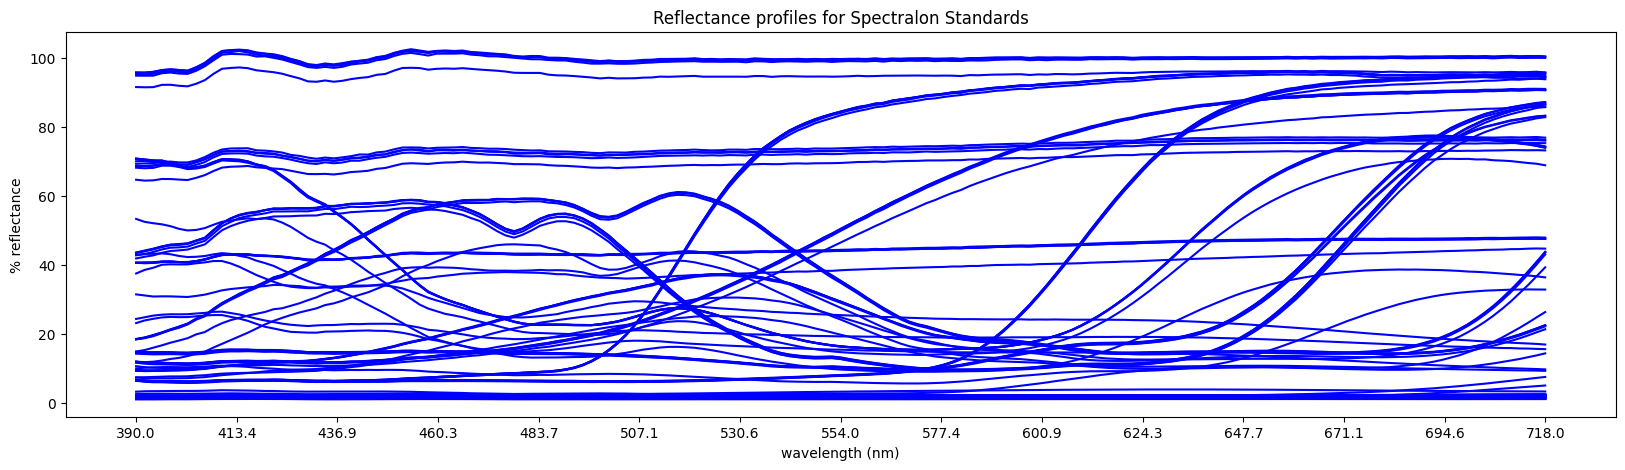

In [16]:
shmsl.plot_reflectance(df=df_reduced.iloc[:,1:],
                 title="Reflectance profiles for Spectralon Standards",
                 ylabel='% reflectance',
                 legend = False,
                 labels=df_reduced.iloc[:,0])

In [18]:

# Compare our calculations to the SHMSL calculations

# Import file with the colorimetric values
# file = './data/input/rsc/covered/RUN/NORM_COVERED-STANDARDS-20241120_2411202203393_RSC.csv'
file = "./data/input/rsc/uncovered/RUN/NORM_UNCOVERED-STANDARDS-20241120_2411202127153_RSC.csv"

# example here gets the contents of only the spectra
df_measurement = shmsl.read_shmsl_rsc_csv(file=file,spectra_only=True)

df_measurement.head()

,offset(cm),390.0,392.0,394.0,396.0,398.0,400.0,402.0,404.0,406.0,...,700.0,702.0,704.0,706.0,708.0,710.0,712.0,714.0,716.0,718.0
0,2.0,2.741,2.758,2.765,2.784,2.765,2.768,2.762,2.795,2.819,...,9.797,9.728,9.691,9.651,9.599,9.582,9.533,9.514,9.452,9.411
1,3.0,6.745,6.504,6.417,6.414,6.344,6.284,6.254,6.281,6.377,...,94.284,94.342,94.514,94.562,94.700,94.854,94.898,95.009,95.191,95.060
2,4.0,6.586,6.386,6.289,6.240,6.191,6.159,6.118,6.171,6.240,...,94.650,94.728,94.863,94.928,94.988,95.253,95.263,95.433,95.562,95.454
3,5.0,6.721,6.483,6.397,6.348,6.342,6.307,6.289,6.326,6.390,...,94.863,94.973,95.136,95.156,95.278,95.484,95.524,95.612,95.750,95.704
4,6.0,6.695,6.480,6.353,6.359,6.339,6.225,6.195,6.258,6.323,...,94.736,94.810,94.984,95.000,95.101,95.375,95.387,95.509,95.646,95.567


In [19]:
# Note: remember the first column has "offsets (cm)"
unique, counts = np.unique(df_reduced.iloc[:,1:] - df_measurement.iloc[:,1:], return_counts=True)

# All values are essentially the same.
# The main differences between our calculations and those by Labview are likely due to minor rounding errors.
# There are a handful of points with significantly varying values.
value_counts = dict(zip(unique, counts))
value_counts_df = pd.DataFrame(list(value_counts.items()), columns=['Value', 'Count'])
value_counts_df



,Value,Count
0,-0.001,1
1,0.000,18147
2,0.001,2
3,1.300,2
4,1.300,1
...,...,...
280,2.449,3
281,2.450,1
282,2.452,1
283,2.455,1


# Validating the Colorimetric Value Calculations

In [20]:
# Compare our calculations to the SHMSL calculations

# file = './data/input/rsc/covered/RUN/NORM_COVERED-STANDARDS-20241120_2411202203393_RSC.csv'
file = './data/input/rsc/uncovered/RUN/NORM_UNCOVERED-STANDARDS-20241120_2411202127153_RSC.csv'

# example here gets the contents of only the spectra
df_m = shmsl.read_shmsl_rsc_csv(file=file,spectra_only=False)

# save colorimetric values
df_c = df_m[['offset(cm)','X','Y','Z']]

# get only spectra and offsets
df_m = pd.concat([df_m[['offset(cm)']], df_m.iloc[:,16:]],axis=1)

df_m.head()

,offset(cm),390.0,392.0,394.0,396.0,398.0,400.0,402.0,404.0,406.0,...,700.0,702.0,704.0,706.0,708.0,710.0,712.0,714.0,716.0,718.0
0,2.0,2.741,2.758,2.765,2.784,2.765,2.768,2.762,2.795,2.819,...,9.797,9.728,9.691,9.651,9.599,9.582,9.533,9.514,9.452,9.411
1,3.0,6.745,6.504,6.417,6.414,6.344,6.284,6.254,6.281,6.377,...,94.284,94.342,94.514,94.562,94.700,94.854,94.898,95.009,95.191,95.060
2,4.0,6.586,6.386,6.289,6.240,6.191,6.159,6.118,6.171,6.240,...,94.650,94.728,94.863,94.928,94.988,95.253,95.263,95.433,95.562,95.454
3,5.0,6.721,6.483,6.397,6.348,6.342,6.307,6.289,6.326,6.390,...,94.863,94.973,95.136,95.156,95.278,95.484,95.524,95.612,95.750,95.704
4,6.0,6.695,6.480,6.353,6.359,6.339,6.225,6.195,6.258,6.323,...,94.736,94.810,94.984,95.000,95.101,95.375,95.387,95.509,95.646,95.567


390.0
718.0


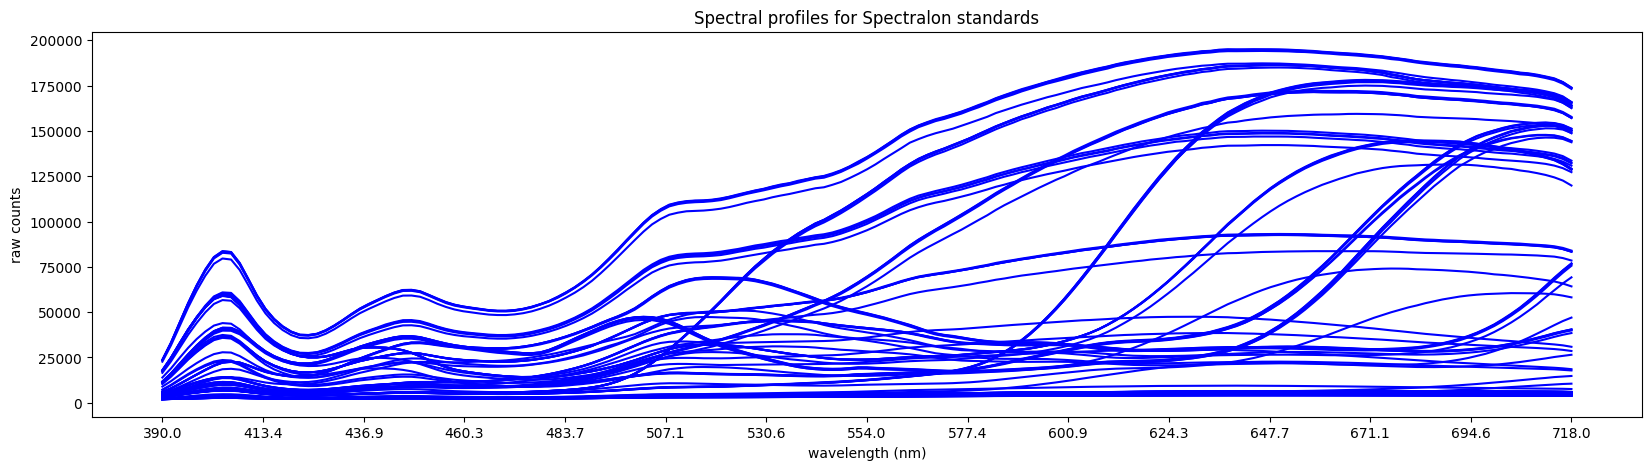

In [21]:
shmsl.plot_reflectance(df=df.iloc[:,1:],
                 title="Spectral profiles for Spectralon standards",
                 ylabel="raw counts",
                 legend=False,
                 labels=df.iloc[:,0]
)
              

In [22]:
wavelengths = df_m.columns[1:].str.strip().astype(float).values
wavelengths

array([ 390.,  392.,  394.,  396.,  398.,  400.,  402.,  404.,  406.,
        408.,  410.,  412.,  414.,  416.,  418.,  420.,  422.,  424.,
        426.,  428.,  430.,  432.,  434.,  436.,  438.,  440.,  442.,
        444.,  446.,  448.,  450.,  452.,  454.,  456.,  458.,  460.,
        462.,  464.,  466.,  468.,  470.,  472.,  474.,  476.,  478.,
        480.,  482.,  484.,  486.,  488.,  490.,  492.,  494.,  496.,
        498.,  500.,  502.,  504.,  506.,  508.,  510.,  512.,  514.,
        516.,  518.,  520.,  522.,  524.,  526.,  528.,  530.,  532.,
        534.,  536.,  538.,  540.,  542.,  544.,  546.,  548.,  550.,
        552.,  554.,  556.,  558.,  560.,  562.,  564.,  566.,  568.,
        570.,  572.,  574.,  576.,  578.,  580.,  582.,  584.,  586.,
        588.,  590.,  592.,  594.,  596.,  598.,  600.,  602.,  604.,
        606.,  608.,  610.,  612.,  614.,  616.,  618.,  620.,  622.,
        624.,  626.,  628.,  630.,  632.,  634.,  636.,  638.,  640.,
        642.,  644.,

Color matching function shape: (165, 3)


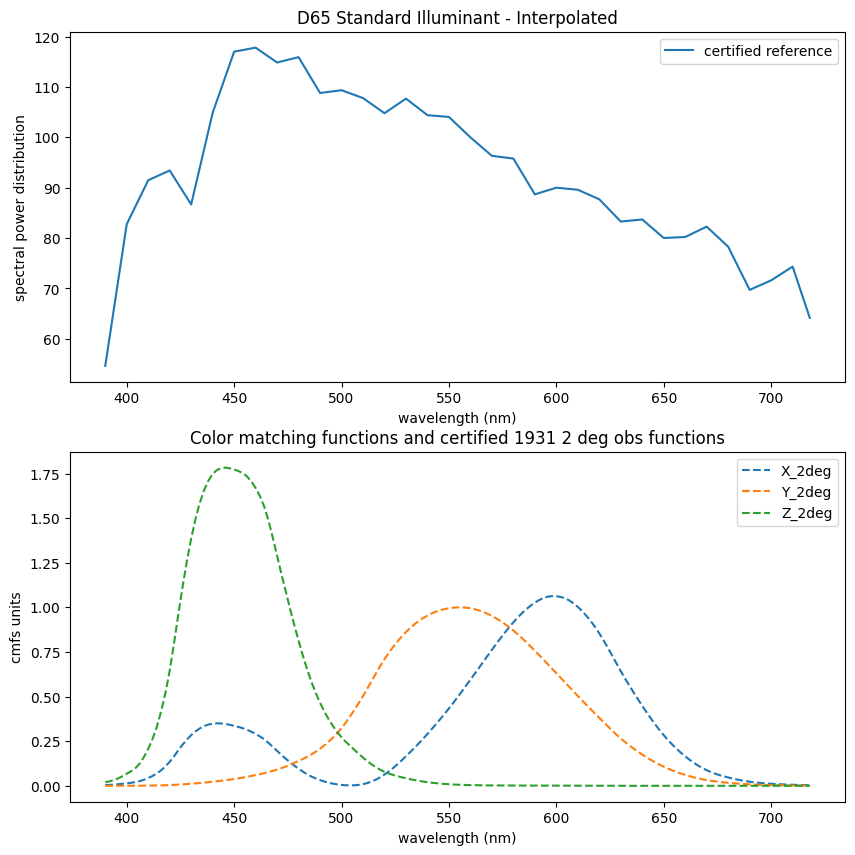

In [23]:
# Here we get color matching function and a standard illuminant using the Colour-Science library
# The values are interpolated at our wavelengths using a Sprague Interpolation,
# which at its heart is a 5 degree polynomial shifting window.

cmfs_id = "CIE 1931 2 Degree Standard Observer"
#cmfs_id = 'CIE 1964 10 Degree Standard Observer'
cmfs = colour.MSDS_CMFS[cmfs_id].copy()
cmfs_interpolated = cmfs[wavelengths]
print(f'Color matching function shape: {cmfs_interpolated.shape}')


fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[1].plot(wavelengths, cmfs_interpolated[:,0], label='X_2deg', linestyle='--')
ax[1].plot(wavelengths, cmfs_interpolated[:,1], label='Y_2deg', linestyle='--')
ax[1].plot(wavelengths, cmfs_interpolated[:,2], label='Z_2deg', linestyle='--')

ax[1].set_xlabel('wavelength (nm)')
ax[1].set_ylabel('cmfs units')
ax[1].legend()
ax[1].set_title("Color matching functions and certified 1931 2 deg obs functions")


# reference illuminant
x = 'D65'
illuminant = colour.SDS_ILLUMINANTS[x].copy()
ax[0].plot(wavelengths, illuminant[wavelengths], label="certified reference")

ax[0].set_xlabel('wavelength (nm)')
ax[0].set_ylabel('spectral power distribution')
ax[0].legend()
ax[0].set_title("D65 Standard Illuminant - Interpolated")

plt.show()

In [24]:
df[0:]

,offset(cm),390.0,392.0,394.0,396.0,398.0,400.0,402.0,404.0,406.0,...,700.0,702.0,704.0,706.0,708.0,710.0,712.0,714.0,716.0,718.0
0,2.0,2284.978,2560.910,2879.194,3194.516,3463.242,3717.819,3914.753,4011.333,3988.187,...,19439.480,19269.148,19144.345,19022.706,18868.538,18756.021,18595.127,18448.829,18148.381,17808.689
1,3.0,3203.962,3790.395,4494.800,5200.510,5802.266,6336.968,6771.094,6949.501,6931.910,...,172773.766,172441.958,172199.030,171790.176,171455.690,170905.434,170263.713,169329.353,167734.276,164798.189
2,4.0,3167.467,3751.759,4438.163,5104.434,5702.525,6244.083,6660.248,6856.667,6817.972,...,173437.722,173140.954,172829.012,172448.429,171971.449,171617.432,170911.640,170078.912,168382.717,165474.673
3,5.0,3198.554,3783.486,4486.181,5164.157,5801.066,6354.413,6799.443,6987.333,6942.120,...,173824.885,173584.534,173321.982,172857.903,172491.738,172028.139,171375.617,170395.200,168711.022,165903.941
4,6.0,3192.358,3782.577,4466.555,5169.933,5798.900,6293.461,6723.096,6930.000,6887.148,...,173592.930,173290.264,173048.261,172577.550,172174.179,171834.274,171133.092,170213.072,168528.769,165668.298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,112.0,2115.221,2310.122,2529.182,2756.646,2951.467,3123.988,3259.427,3326.667,3311.915,...,5776.976,5759.073,5755.255,5755.667,5744.445,5739.337,5728.039,5709.654,5671.928,5613.501
110,113.0,2119.720,2324.364,2542.503,2760.222,2981.383,3140.043,3292.922,3357.333,3346.887,...,5861.952,5858.145,5851.430,5847.059,5842.114,5830.341,5814.558,5798.858,5764.322,5705.554
111,114.0,2122.937,2313.516,2547.212,2774.736,2962.600,3138.158,3273.528,3346.000,3332.153,...,5879.333,5877.493,5869.842,5864.018,5853.363,5850.280,5845.242,5823.885,5775.742,5714.557
112,115.0,2121.738,2315.152,2532.154,2773.376,2975.075,3144.260,3300.650,3348.000,3331.582,...,5921.357,5916.695,5915.770,5911.059,5899.112,5892.583,5879.593,5846.191,5819.655,5749.327


In [25]:
df = shmsl.tristimulus_xyz_calculation(df_m)
df

max wavelength: 718.0
min wavelength: 390.0
max reflectance: 1.0
min reflectance: 0.01192
shape reflectance: (114, 165)
shape illuminant: (165,)
shape cmfs: (165, 3)
k proportionality: 0.00946430921382997
bandwidth: 2
max XYZ: 106.91549565196924
min XYZ: 1.1866709001285296


,offset,X,Y,Z
0,2.0,4.930943,3.829772,2.930503
1,3.0,27.589403,17.006820,7.038899
2,4.0,27.596339,16.962118,6.908514
3,5.0,27.870784,17.181289,7.082262
4,6.0,27.831776,17.124911,7.007025
...,...,...,...,...
109,112.0,2.029270,2.112723,2.286816
110,113.0,2.066797,2.150736,2.327041
111,114.0,2.067560,2.150425,2.324568
112,115.0,2.091964,2.177560,2.348299


In [26]:
df_c

,offset(cm),X,Y,Z
0,2.0,4.787,3.759,3.289
1,3.0,25.823,16.357,7.867
2,4.0,25.817,16.308,7.717
3,5.0,26.086,16.524,7.911
4,6.0,26.046,16.467,7.830
...,...,...,...,...
109,112.0,2.069,2.112,2.549
110,113.0,2.107,2.150,2.594
111,114.0,2.107,2.149,2.590
112,115.0,2.132,2.176,2.615


In [27]:
# import 

df_certified = pd.read_csv("./data/input/rsc/certified_spectralon_standards_D65_1931_2deg.csv")

df_certified = (df_certified
                .rename(columns={"Standard":'color'})
                .set_index('color').sort_index()
    )

df_certified[['x','y']] = (df_certified[['X','Y','Z']]
                           .apply(lambda row: colour.XYZ_to_xy(row / 100), axis=1)
                            .apply(lambda row: pd.Series(row, index=['x','y'])
                            )
                           )
df_certified 

,X,Y,Z,x,y
color,,,,,
blue,21.67,21.87,64.73,0.200148,0.201995
cyan,28.87,40.61,59.08,0.224564,0.315884
green,21.17,30.61,22.46,0.285156,0.412311
orange,56.70,52.59,14.61,0.457627,0.424455
purple,15.31,13.90,17.63,0.326857,0.296755
red,26.90,16.61,7.34,0.529007,0.326647
violet,28.97,24.51,48.89,0.282993,0.239426
yellow,69.72,72.12,8.73,0.463040,0.478980


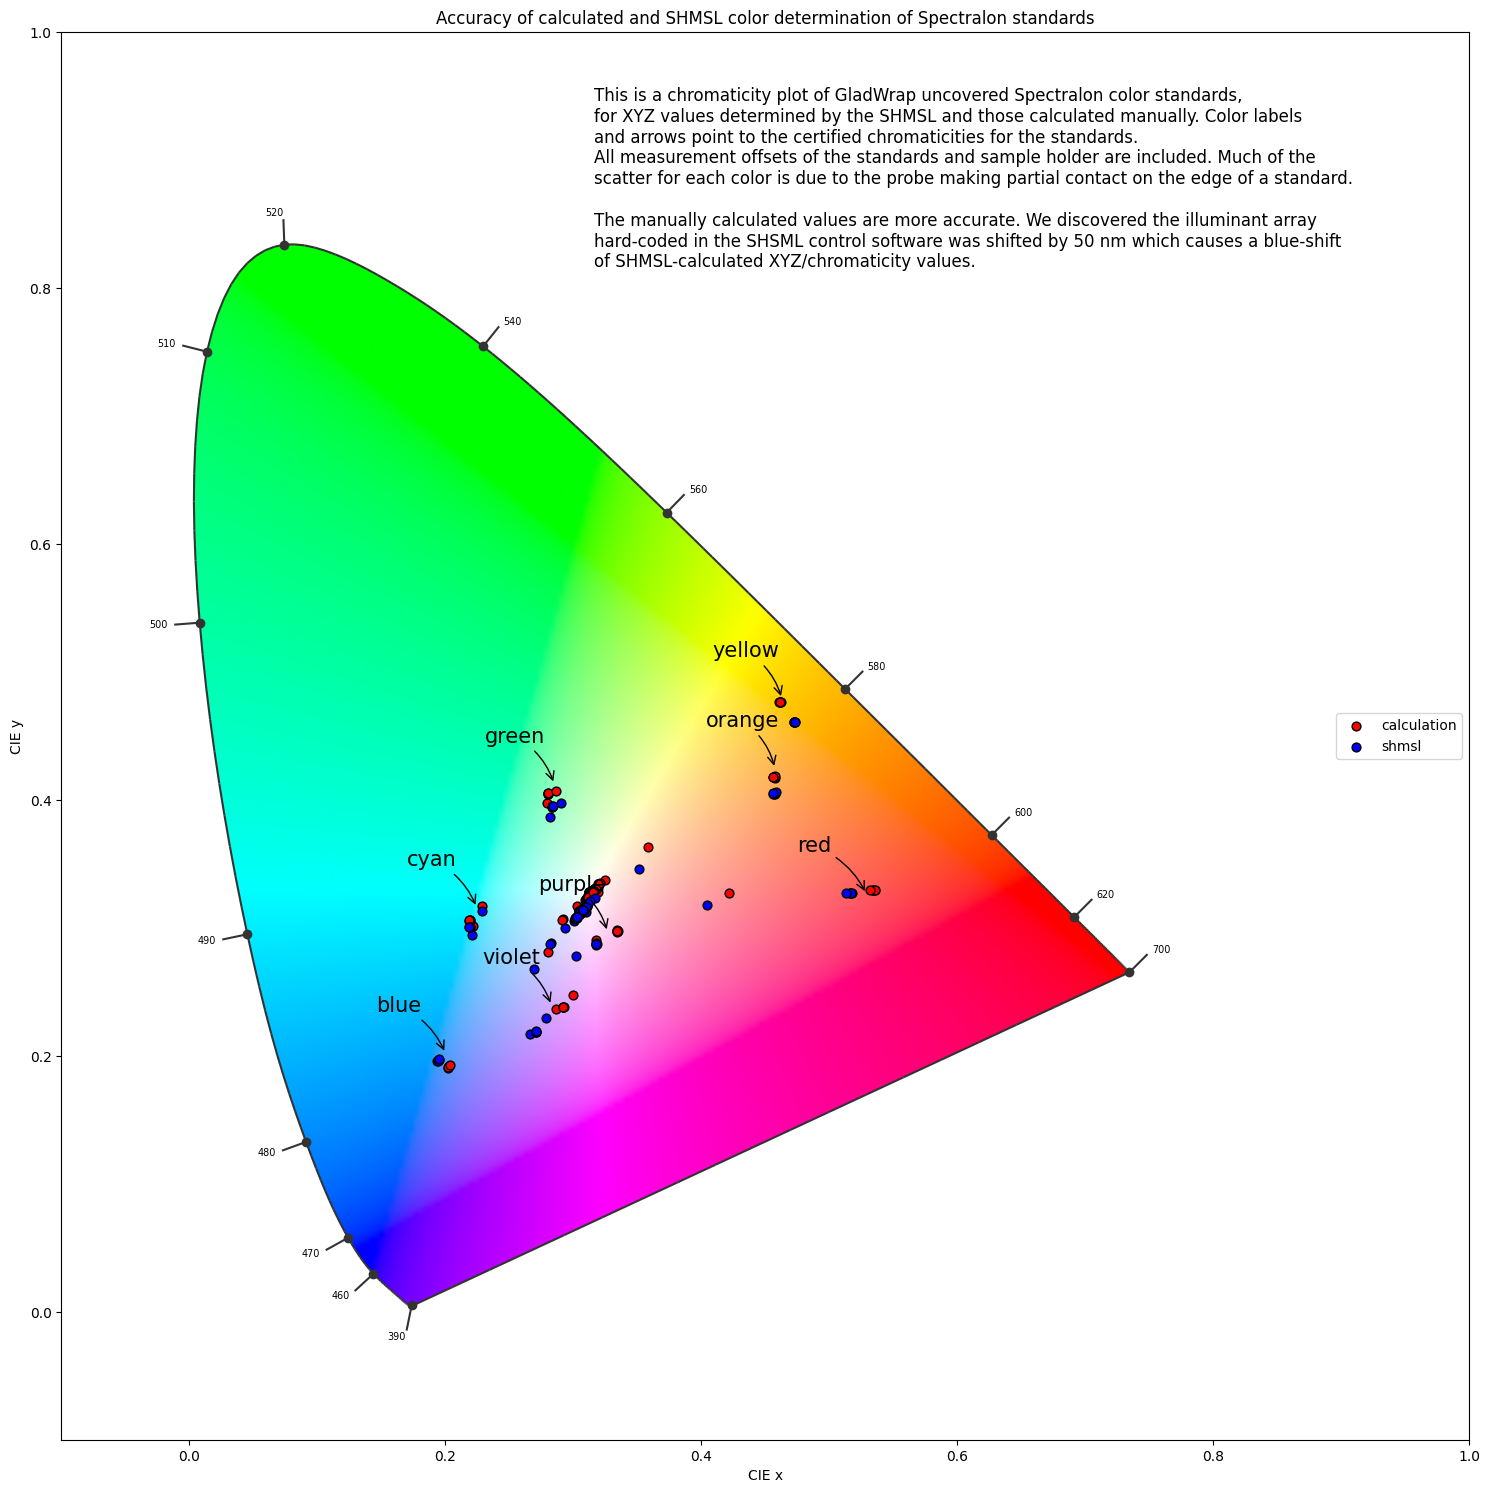

In [28]:
fig, ax = cp.plot_chromaticity_diagram_CIE1931(show=False, figsize=(20,20), show_spectral_locus=True)

fig.set_size_inches(15, 15)

ax.set_title('SHMSL measured vs certified chromaticities for spectralon standards')

df_xy = (df[['X', 'Y', 'Z']]
            .apply(lambda row: colour.XYZ_to_xy(row / 100), axis=1)
            .apply(lambda row: pd.Series(row, index=['x','y'])
                   )
            )

plt.scatter(df_xy['x'], df_xy['y'], s=40, facecolors='r', edgecolors='k', label="calculation")


df_xy = (df_c[['X', 'Y', 'Z']]
            .apply(lambda row: colour.XYZ_to_xy(row / 100), axis=1)
            .apply(lambda row: pd.Series(row, index=['x','y'])
                   )
            )

plt.scatter(df_xy['x'], df_xy['y'], s=40, facecolors='b', edgecolors='k', label ="shmsl")

# Annotating the plot.
for idx, row in df_certified.iterrows():
    plt.annotate(
        text=idx,
        xy=row[['x', 'y']],
        xytext=(-50, 30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=-0.2"),
        fontsize="15"
    )

plt.annotate(
    text="""
    This is a chromaticity plot of GladWrap uncovered Spectralon color standards,
    for XYZ values determined by the SHMSL and those calculated manually. Color labels
    and arrows point to the certified chromaticities for the standards.
    All measurement offsets of the standards and sample holder are included. Much of the
    scatter for each color is due to the probe making partial contact on the edge of a standard.
    
    The manually calculated values are more accurate. We discovered the illuminant array
    hard-coded in the SHSML control software was shifted by 50 nm which causes a blue-shift
    of SHMSL-calculated XYZ/chromaticity values.
    """,
    xy= (0.3,0.8),
    # xytext=(-50, 30),
    # textcoords="offset points",
    # arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=-0.2"),
    fontsize="12"
)

plt.legend(loc='right')

# Displaying the plot.
cp.render(
    title='SHMSL Accuracy',
    show=False,
    limits=(-0.1, 0.9, -0.1, 0.9),
    x_tighten=False,
    y_tighten=False,
    bounding_box = [-.1,1,-.1,1]
)

fig = plt.gcf()
ax = fig.gca()
ax.set_title("Accuracy of calculated and SHMSL color determination of Spectralon standards")
fig.savefig("./data/output/chromaticity_plots.svg")
plt.show()

# Disregard Everything Below Here


In [4]:
from itertools import chain

# indices which accurately capture entire standards

locations = {
    "red": list(range(2,6)),
    "orange": list(range(10,13)),
    "yellow": list(range(18,22)),
    "green": list(range(26,29)),
    "cyan": list(range(34,37)),
    "blue": list(range(43,46)),
    "violet" :list(range(50,53)),
    "purple": list(range(59,62)),
    "white":list(range(65,69)),
    "gray75":list(range(73,77)),
    "gray50": list(range(81,84)),
    #"gray3": list(range(89,93)) #,
    "black": list(range(89,92))
}